In [1]:
11

11

## 한글 font

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose   

todo
- season 추가 : (1: 봄, 2: 여름, 3: 가을, 4:겨울)
- weather 추가 : (1: 맑음, 2 : 옅은 안개, 약간흐림,
 3: 약간의 눈이나 비, 흐림, 4: 폭우나 눈과 짙은 안개)

## packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from scipy import stats

In [4]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

In [5]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/train.csv')
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/test.csv')
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/sample_submission.csv')

## preprocessing


### train set

In [6]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train['year'] = train['date'].dt.year 
train['month'] = train['date'].dt.month 
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

# train['sunshine_sum'] = train[['sunshine_sum']].fillna(0)
train['precipitation'] = train[['precipitation']].fillna(0)

train['rental'] = train['rental'].astype(float)

### test set

In [7]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek

# test['sunshine_sum'] = test[['sunshine_sum']].fillna(0)
test['precipitation'] = test[['precipitation']].fillna(0)


## 렌탈계 분포



In [8]:
train.groupby('year').mean()[['rental']]

,rental
year,
2018,27106.860390
2019,52944.056497
2020,65004.315934


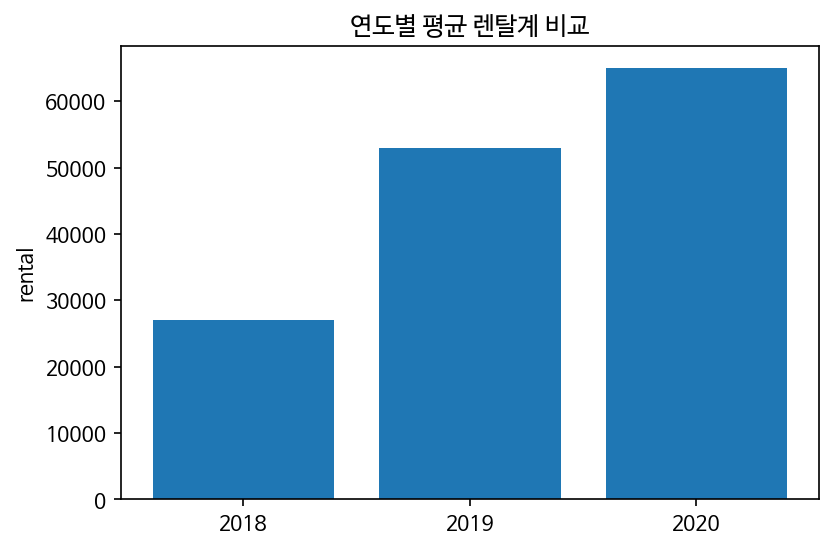

In [9]:
# 2018년이 가장 적고 2020년이 가장 많다.
# 렌탈계가 증가하는 추세이다.
x = ['2018', '2019', '2020']
y = [train.groupby('year').mean()['rental'][2018],
     train.groupby('year').mean()['rental'][2019],
     train.groupby('year').mean()['rental'][2020]]

plt.figure(dpi=150)
plt.ylabel('rental')
plt.title('연도별 평균 렌탈계 비교')
plt.bar(x,y)
plt.show()

In [10]:
train.groupby('month').mean()[['rental']]

,rental
month,
1,15635.505376
2,16531.890244
3,33280.240000
4,51160.049383
5,64329.746988
6,79362.626866
7,63752.500000
8,52458.532609
9,71501.704545


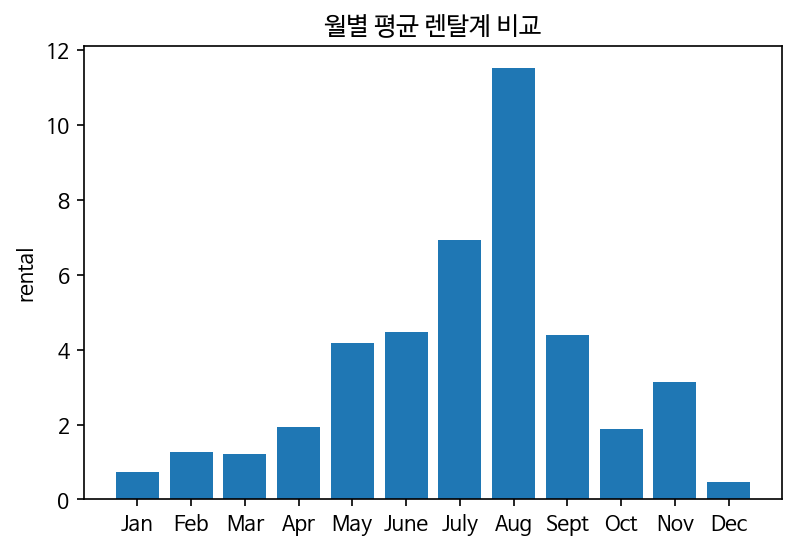

In [11]:
# 8월에 가장 많고 12월에 가장 적다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['precipitation'][1],
     train.groupby('month').mean()['precipitation'][2],
     train.groupby('month').mean()['precipitation'][3],
     train.groupby('month').mean()['precipitation'][4],
     train.groupby('month').mean()['precipitation'][5],
     train.groupby('month').mean()['precipitation'][6],
     train.groupby('month').mean()['precipitation'][7],
     train.groupby('month').mean()['precipitation'][8],
     train.groupby('month').mean()['precipitation'][9],
     train.groupby('month').mean()['precipitation'][10],
     train.groupby('month').mean()['precipitation'][11],
     train.groupby('month').mean()['precipitation'][12]]

plt.figure(dpi=150)
plt.ylabel('rental')
plt.title('월별 평균 렌탈계 비교')
plt.bar(x,y)
plt.show()

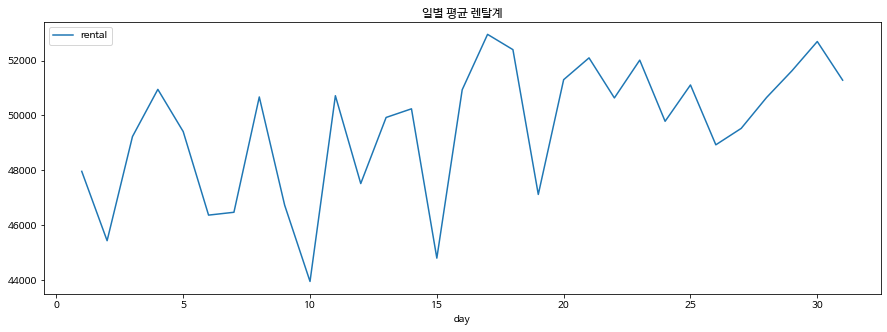

In [12]:
train.groupby('day').mean()[['rental']].plot(figsize=(15,5))
plt.title('일별 평균 렌탈계')
plt.show()

In [13]:
test['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [14]:
# train은 2018-2020, test는 2021 데이터이다.
# train의 year와 test의 year는 전혀 다른 값을 갖는다.
# 따라서 year는 column으로 사용할 수 없다 : year column을 feature에서 제거한다.
train['year'].unique(), test['year'].unique()

(array([2018, 2019, 2020]), array([2021]))

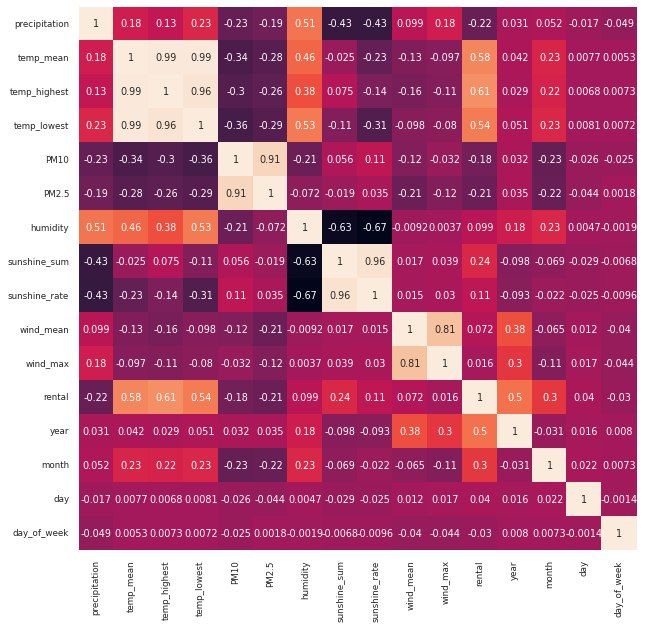

In [15]:
train_corr = train.corr()
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(train_corr, annot=True, cbar=False)
plt.show()

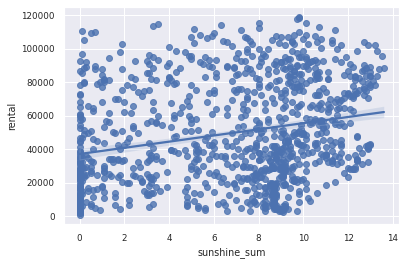

In [16]:
sns.regplot(x='sunshine_sum', y='rental', data=train)

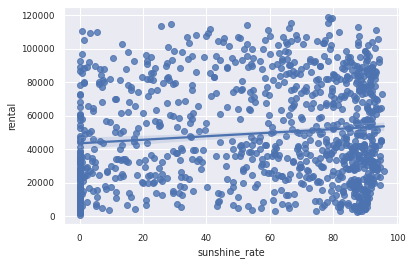

In [17]:
sns.regplot(x='sunshine_rate', y='rental', data=train)

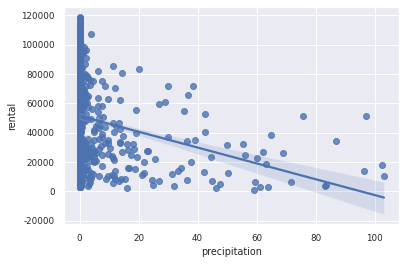

In [18]:
sns.regplot(x='precipitation', y='rental', data=train)

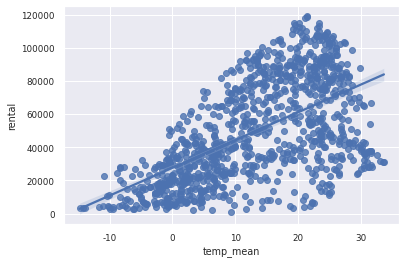

In [19]:
sns.regplot(x='temp_mean', y='rental', data=train)

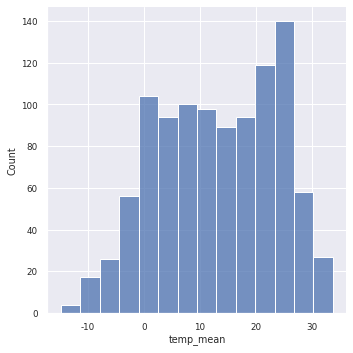

In [20]:
sns.displot(train['temp_mean'])

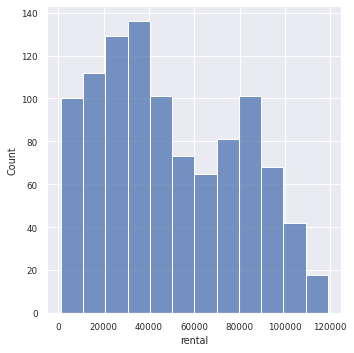

In [21]:
# x axis rental : target rental
# y axis count  : number of rental
# 회귀모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야한다.
# 하지만 현재 rental은 정규분포를 따르지 않는다.
# 따라서 rental을 그대로 사용해 모델링하면 좋은 성능을 기대하기 어렵다. 
sns.displot(train['rental'])
plt.show()

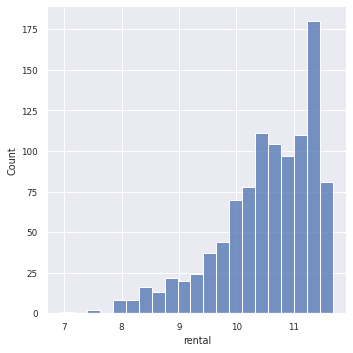

In [22]:
# 데이터 분포를 정규분포에 가깝게 만들기 위해 로그변환을 사용한다.
# 로그 변환은 데이터가 왼쪽으로 편향되어 있을 때 사용한다.
# 아래 그래프는 정규 분포가 아니다. 
sns.displot(np.log(train['rental']))
plt.show()

In [23]:
train = train[train['sunshine_rate'] != 0]
train.dropna(axis=0, subset=['sunshine_sum'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## validation models

In [24]:
y = train.rental
X = train.drop(['rental', 'date'], axis=1)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

In [26]:
X_train.head(1)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day,day_of_week
652,0.0,14.6,20.8,9.0,24.0,15.0,58.3,9.8,87.5,1.6,3.6,2019,10,16,2


In [27]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('MAE : ', mae)

MAE :  5090.253208556149


In [28]:
xgb = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('MAE : ', mae)

MAE :  4551.6350149878845


## test model

In [29]:
train = shuffle(train)
train.head(3)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
697,2019-11-30,0.0,4.1,9.3,-1.4,44.0,34.0,42.6,5.3,54.1,1.7,3.4,38366.0,2019,11,30,5
1077,2020-12-14,0.0,-7.7,-5.0,-9.7,23.0,12.0,49.1,8.9,92.7,3.4,5.3,28030.0,2020,12,14,0
976,2020-09-04,0.0,23.3,27.5,19.9,24.0,11.0,63.9,10.1,78.3,2.7,5.6,115059.0,2020,9,4,4


In [30]:
y = train.rental
X = train.drop(['rental', 'date'], axis=1)

test = test.drop('date', axis=1)

In [31]:
test_model = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)
test_model.fit(X, y)
submission['rental'] = test_model.predict(test)

In [32]:
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submissions/submission-2022-06-19-ik.csv', index=False)

## submission result
- rfr보다 xgbboost의 성능이 더 좋다.


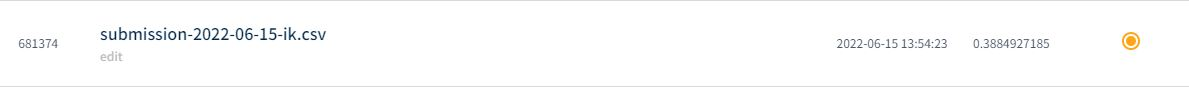

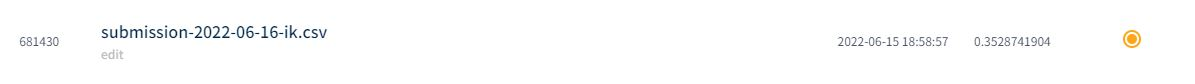